<a href="https://colab.research.google.com/github/IEXE-Tec/mcda-marketing/blob/main/04_ab_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A/B Testing**

Este Notebook esta basado en varis de los ejemplos que vienen en la pagina de Kaggle.

En este Colab diseñaremos, crearemos y evaluaremos una prueba A/B: 


1. Diseñaremos el Experimento 
2. Recollecion de Datos y ETL
3. EDA 
4. Pruebas de Hipotesis
5. Analisis de Resultados

In [3]:
# Packages imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms

%matplotlib inline

# Diseño de Experimento

Imagina que tu marca ha decidido rediseñar su pagina de internet con el fin de obtener mas conversiones. Tu fronted UX/UI esta listo para implementar el nuevo layout de la pagina. El objetivo de este rediseño es aumentar el numero de conversiones, que en este caso es que los usuarios creen una cuenta.  

Tu primera tarea es diseñar el experimento y explicar el diseño a tu equipo.

Ademas ya realizaste un analisis exploratorio de los datos y decidiste que primero evaluaran un efecto agregado sin segmentar los grupos.

## Diseño de la prueba de hipotesis

Como es costumbre comenzaremos estableciendo la prueba de hipotesis. Definamos:  
$p_0:= \text{ la probabilidad de conversion de la pagina original.}$  
$p:=\text{ la probabilidad de conversion de la pagina rediseñada}$

### Hipotesis nula

En este caso la hipotesis nula $H_0$ es que el nuevo diseño de la pagina no afecta el numero de conversiones:  


> $H_0: \ \ \ \ \ \   p=p_0$  







### Hipotesis Alternativa

El rediseño de la pagina afecta la probabilidad de conversion:  
> $H_1: \ \ \ \ \ \   p \neq p_0$ 
   
Nota que la hipotesis es que es diferente, no indica si aumento o disminuyo con el rediseño. Esto quiere decir que usaremos una [prueba de dos colas](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests)  

### Nivel de significancia

En este caso como es costumbre utilizaremos un nivel de significancia de $5%$ como es constumbre:  
> $ \alpha=.05$  

Esto quiere decir que nuestro nivel de confianza es de $95%$, oues:  
> $(1- \alpha) = .95$

## Grupos de Control

En este caso el grupo de **control** recibira el diseño viejo, y el grupo de **tratamiento** recibira el nuevo diseño.

No te preocupes en este caso el equipo de front te garantiza que la pagina que se mostrara al usuario es **completamente aleatoria**.

## Efecto Minimo

Tu equipo te pasa las siguientes metricas:
+ CPC = 5
+ Costo de Mantenimiento de usuarios es $Co = 10$
+ CLTV despues de Convertir sin costos es $ V = 200$
+ La conversion actual es .19 osea $p_0=.19$

Esto implica que el CLTV neto despues de convertir es:  
+ $p_0 \times (V-Co) - CPC = .19 \times (200-10) - 5 = $

Donde:  
+ p_0 \times (V-Co) es la venta esperada para cualquier usuario que vea nuestro anuncio, de ahi que la multipliquemos por $p_0$. Solo vendemos $V$ y pagamos $Co$ si el usuario convierte.  
+ CPC es el gasto promedio por usuario que es redirigido a nuestra pagina, por eso no hay que multiplicarlo. En promedio el costo por click es 5, la proporcion que da click ya viene implicita en la metrica.

Grafiquemos cuanto cambio nuestro CLTV esperado dada nuestra nueva conversion $p$, sin incluir costos de rediseño:
+ Cambio en proporciones $p-p_0$
+ Cambio en CLTV sin costos de rediseño: $(p-p_0) \times (V-Co) - CPC$ 
>   $(p-.19) \times (200-10) - 5$

El CPC se mantiene constante pues el rediseño es de la pagina no de la forma en que llegan lo usuarios por lo que no afecta la proporcion de clicks.

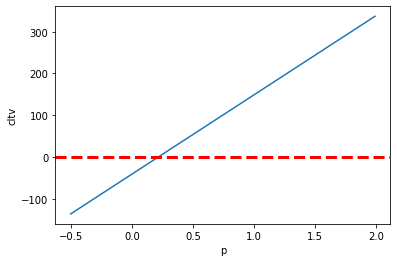

In [63]:
p = pd.Series(list(range(-50,200,1)))/100
cltv = (p-.19)*(200-10)-5

evaluacion = pd.DataFrame({'p':p, 'cltv':cltv})
sns.lineplot(data=evaluacion, x='p', y='cltv')
plt.axhline(0, ls='--', linewidth=3, color='red')

## Tamaño de Muestra

 De terminemos el poder o potencia de nuestro analisis de nuestra prueba. Que depende de 3 factores:  
 > + [Poder Estadistico](https://es.wikipedia.org/wiki/Poder_estad%C3%ADstico) de nuestra prueba:= Este se define como la probabilidad de encontrar una diferencia estadisticamente significativa entre los dos grupos, **dado que la diferencia existe**. Generalmente se utiliza un valor de $.8$ 
 > + [Nivel de significancia](https://es.wikipedia.org/wiki/Significaci%C3%B3n_estad%C3%ADstica): Es la $\alpha$ que decidimos previamente y se define como la probabilidad de rechazar la hipotesis nula dado que es verdadera.  
 > + Efecto: Que tan grande es el efecto de nuestra muestra.


### Calculemos el tamaño de la muestra

+ [sms.proportion_effectsize()](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html)
+ [sms.NormalIndPower()](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.NormalIndPower.html): Usamos una normal pues estamos calculando una diferencia de proporciones.

In [40]:
# Calculando el tamaño del efecto
efecto = sms.proportion_effectsize(0.13, 0.15) 

# Calculemos el minimo tamaño de muestra que necesitamos
n_muestra = sms.NormalIndPower().solve_power(
    efecto, 
    power=0.8, 
    alpha=0.05 
    )                                                  

print(n_muestra)

4719.4740575998185


Bueno nuestro minimo tamaño de muestra es de **4719 individuos por grupo**.

Nota como en este punto no hemos utilizado datos, mas que para evaluar hipoteticamente la forma de aleatorizar (de forma implicita determinamos que no era necesario segementar). Toda la determinacion del tamaño de la muestra se hizo independiente de los datos.

# ETL

Por ahora imaginemos que el experimento ya se implemento, y estas accediendo a los resultados. Dada las limitaciones actuales seria muy dificil implementar el experimento 100% en la clase.  
En la realidad los datos los obtuvimos de [Kaggle](https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv)

In [10]:
ab = pd.read_csv('https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/ab_data.csv')
ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [14]:
ab.shape

(294478, 5)

In [12]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


# EDA

## Usuarios

### Usuarios en los dos grupos

In [15]:
ab.groupby(['group'])['converted'].count()

group
control      147202
treatment    147276
Name: converted, dtype: int64

In [17]:
ab['user_id'].nunique()

290584

In [20]:
id_trat = ab[ab['group']=='treatment']['user_id']
id_control = ab[ab['group']!='treatment']['user_id']
print(f'Usuarios con tratamiento: {id_trat.nunique()}')
print(f'Usuarios en control: {id_control.nunique()}')


Usuarios con tratamiento: 146284
Usuarios en control: 146195


In [24]:
id_filtrado = id_trat[id_trat.isin(id_control)]
print(f'Usuarios en los dos grupos: {id_filtrado.nunique()}')

Usuarios en los dos grupos: 1895


En este caso hay solo hay 1895 usuaarios que estan los dos grupos. Desagamonos de ellos por le momento, aunque en un futuro podria servir para evaluar el efecto repetido de la pagina, pero en este momento son tan pocos que no vale la pena.

In [26]:
ab = ab[~ab['user_id'].isin(id_filtrado)]

### Usuarios repetidos

In [31]:
usuarios_duplicados = ab.drop_duplicates('user_id').shape[0]
print(ab.shape)
print(usuarios_duplicados)
print(f"Diferencia {ab.shape[0] - usuarios_duplicados}")

(290688, 5)
288689
Diferencia 1999


En este caso la diferencia es tan pequeña, y tenemos tantos datos que podemos eliminarlos o dejarlos.

In [38]:
sesiones = ab['user_id'].value_counts(ascending=False)
ids_repetidos = sesiones[sesiones > 1].index
ab = ab[~ab['user_id'].isin(ids_repetidos)]
print(ab.shape)

(286690, 5)


In [39]:
ab.groupby(['group'])['converted'].count()

group
control      143293
treatment    143397
Name: converted, dtype: int64

Bueno despues de limpiar los datos observamos que seguimos teniendo mucho mas usuarios de los requeridos, lo que es buena señal.

## EDA de resultados

In [42]:
prob_conversion = ab.groupby('group')['converted']

# Std de la conversion
std_p = lambda x: np.std(x, ddof=0)             
# Error estandar
se_p = lambda x: stats.sem(x, ddof=0)       

prob_conversion = prob_conversion.agg([np.mean, std_p, se_p])
prob_conversion.columns = ['conversion_rate', 'std_deviation', 'std_error']


prob_conversion.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.323,0.001


Inmediatamente notamos que la conversiones son muy similares, osea $p$ e smuy cercano a $p_0$.  
+ $p_0=.12$
+ $p=.119$

# Prueba de hipotesis

In [44]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [48]:
# Calculemos los usuarios en cada grupo
control = ab[ab['group'] == 'control']['converted']
tratamiento = ab[ab['group'] == 'treatment']['converted']
n_con = control.count()
n_trat = tratamiento.count()
successes = [control.sum(), tratamiento.sum()]
nobs = [n_con, n_trat]
nobs

[143293, 143397]

+ [proportions_ztest()](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html): Test de proporciones z.
+ [proportion_confint()](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html): Calcular los intervalos de confianza para nuestros estimadores $p$ y $p_0$.

In [50]:
# Test de proporciones
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'Intervalo de confianza para p_0 al 95%: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'Intervalo de confianza de p al 95%: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.19
p-value: 0.232
Intervalo de confianza para p_0 al 95%: [0.118, 0.122]
Intervalo de confianza de p al 95%: [0.117, 0.120]


# Conclusiones

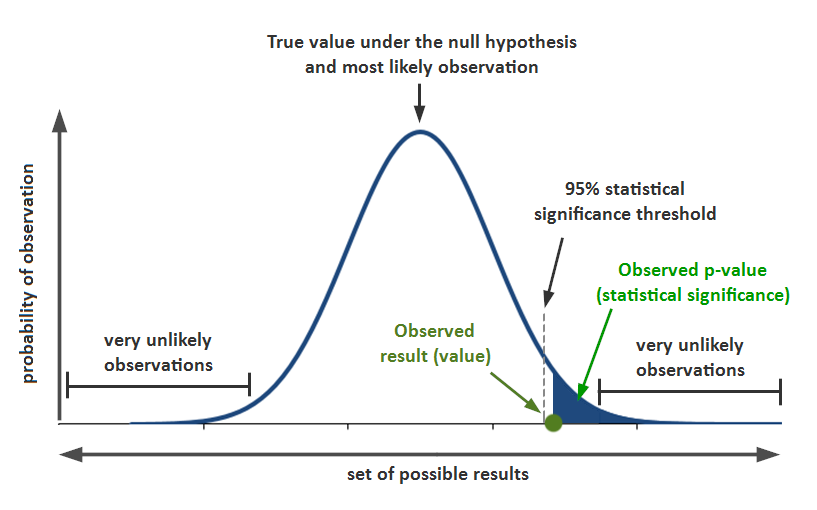

Dado que nuestro **p-value** fue de un terrible $.232$ muy lejos de nuestra $\alpha$ de $.05$ no tenemos evidencia que soporte rechazar $H_0$. Recordemos que $H_0$ es $p=p_0$ lo que quiere decir que el rediseño probablemente no tubo ningun efecto.

Ademas observando nuestros intervalos de confianza al $95$% podemos obserbar que nuestro efecto deseado de por lo menos $15$% no se encuentra ahi:


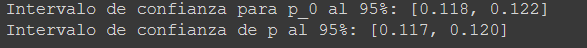

Es mas incluso el efecto de la nueva pagina parece ser negativo en el mejor caso! No pasa nada, estos resultados aveces pasan...